In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
# from scipy import spatial

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

## Observed mutations

#### Prepapre table for best friend of KP

In [3]:
mut_tcga = pd.read_csv("../data/processed/mutations.csv")

mut_tcga = mut_tcga[mut_tcga.Strand == 1]
mut_tcga['sbs192heavy'] = mut_tcga['Mut'].apply(rev_comp)
mut_tcga['sbs12heavy'] = mut_tcga['sbs192heavy'].str.slice(2,5)
mut_tcga.drop(['Mut', 'sbs192heavy', 'Strand', 'AltCodon', 'Codon', 'PosInCodon', 'PosInGene', 'Context', 'Nuc', 'Label'], axis=1, inplace=True)
print(mut_tcga.shape)
mut_tcga.head()

(6209, 8)


,tissue,TurnOverDays,tumor_var_freq,Pos,Type,GeneName,TBSS,sbs12heavy
0,Bladder,200.0,38.7900,2680,rRNA,RNR2,10487.0,A>G
1,Pancreas,360.0,21.0500,2680,rRNA,RNR2,10487.0,A>G
2,Bladder,200.0,10.1400,6011,CDS,COX1,426.0,A>G
3,Bladder,200.0,37.3900,7706,CDS,COX2,3816.0,C>T
4,Esophagus,11.0,0.7013,7706,CDS,COX2,3816.0,C>T


In [36]:
mut_tcga.to_csv('../data/processed/all_muts_strand1.csv', index=False)

### TCGA

In [4]:
mut_tcga = pd.read_csv("../data/processed/mutations.csv")
print(mut_tcga.shape)
mut_tcga.head()

(7611, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [5]:
mut_tcga.tissue.value_counts()

Liver              1273
Pancreas            861
Kidney              822
Prostate            739
Breast              689
Esophagus           409
Ovary               402
Lymphoid            316
Lung                268
CNS                 262
Colon/Rectum        224
Skin                217
Stomach             210
Thyroid             168
Bone/SoftTissue     155
Head/Neck           146
Uterus              145
Bladder              99
Biliary              90
Myeloid              78
Cervix               38
Name: tissue, dtype: int64

### gTEX

In [6]:
mut_gtex = pd.read_csv('../data/stem_and_workers/gtex_annotated.csv')
print(mut_gtex.shape)
mut_gtex.head()

(2565, 24)


,Position,Mutation,SRR,AF,tissue,subject,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,...,Pos,Nuc,Context,Strand,Type,product,PosInGene,PosInCodon,Codon,Mut
0,1554,1554_A,SRR1500555,0.1021,Artery - Tibial,GTEX-1117F,13,35.7,186,0.0012,...,1554,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A
1,1554,1554_A,SRR1096458,0.0347,Ovary,GTEX-TML8,14,38.4,144,0.0021,...,1554,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A
2,1554,1554_A,SRR1102224,0.0309,Colon - Sigmoid,GTEX-V955,20,35.2,906,0.0011,...,1554,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A
3,1554,1554_A,SRR1433514,0.0326,Cells - Transformed fibroblasts,GTEX-WY7C,30,33.2,491,0.0019,...,1554,G,GGA,1,rRNA,12S ribosomal RNA,-1,-1,NaN,G[G>A]A
4,16215,16215_A,SRR1413373,0.0525,Ovary,GTEX-1117F,13,37.9,362,0.0000,...,16215,G,AGC,-1,D-loop,NaN,-1,-1,NaN,A[G>A]C


In [7]:
mut_gtex.tissue.value_counts()

Whole Blood                                  452
Cells - Transformed fibroblasts              330
Esophagus - Mucosa                           191
Cells - EBV-transformed lymphocytes          162
Skin - Sun Exposed (Lower leg)               122
Nerve - Tibial                               113
Thyroid                                      110
Liver                                         94
Adrenal Gland                                 83
Muscle - Skeletal                             81
Artery - Aorta                                79
Lung                                          70
Adipose - Subcutaneous                        62
Artery - Tibial                               49
Pituitary                                     43
Testis                                        40
Prostate                                      40
Ovary                                         38
Skin - Not Sun Exposed (Suprapubic)           37
Kidney - Cortex                               36
Pancreas            

## Expected mutations

In [8]:
with open("../data/processed/expected_sbs12.json") as handle:
    exp_muts12 = json.load(handle)

pd.DataFrame(exp_muts12).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A>C,766,766,3148,325,339,861,527,4785
A>G,766,1308,3148,325,339,861,527,4785
A>T,766,766,3148,325,339,861,527,4785
C>A,817,817,3579,390,371,650,353,4810
C>G,817,817,3579,390,371,650,353,4810
C>T,817,1872,3579,390,371,650,353,4810
G>A,96,178,1294,137,150,451,217,2015
G>C,96,96,1294,137,150,451,217,2015
G>T,96,96,1294,137,150,451,217,2015
T>A,261,261,2758,286,260,548,405,3834


## Spectra compares

In [9]:
def get_asymmetry(spectrum: pd.DataFrame):
    """
    work with light strand

    - AhGh/ChTh
    - Tv/ChTh
    """
    dct = spectrum.set_index("Mut")['MutSpec'].to_dict()
    tv_mut_types = ['A>C', 'A>T', 'C>A', 'C>G',  'G>C', 'G>T', 'T>A', 'T>G']
    dct['Tv'] = 0.
    for x in tv_mut_types:
        dct['Tv'] += dct.get(x, 0.)
    
    try:   
        tc_ga = dct.get('T>C') / dct.get('G>A')
    except:
        tc_ga = None
    try:   
        tv_ga = dct.get('Tv') / dct.get('G>A')
    except:
        tv_ga = None
    try:   
        tv_tc = dct.get('Tv') / dct.get('T>C')
    except:
        tv_tc = None
    
    return [tc_ga, tv_ga, tv_tc]

In [10]:
mut_tcga_ex_ctrl_reg = mut_tcga[(mut_tcga.Type != "D-loop") & (mut_tcga.Strand == 1)]
mut_gtex_ex_ctrl_reg = mut_gtex[(mut_gtex.Type != "D-loop") & (mut_gtex.Strand == 1)]
mut_tcga_ex_ctrl_reg.shape[0], mut_gtex_ex_ctrl_reg.shape[0]

(6209, 1985)

### Tissue specific spectra

In [11]:
data = []
mut = mut_tcga_ex_ctrl_reg
for tissue, sample in mut.groupby('tissue'):
    if len(sample) < 20:
        print(f"Don't calculate spectrum for {tissue}: less than 20 mutations")
        continue

    spectrum = calculate_mutspec(
        sample, exp_muts12['ExDloop'], fill_unobserved=False)
    one = get_asymmetry(spectrum)
    data.append([tissue] + one)

asymmetry_tcga = pd.DataFrame(
    data, columns=['tissue', 'AhGh/ChTh', 'Tv/ChTh', 'Tv/AhGh']
).set_index('tissue')

In [21]:
CancerTissue = (
    'Bladder','Bone/SoftTissue','Breast','Biliary','Cervix','Lymphoid','Myeloid',
    'Colon/Rectum','Prostate','Esophagus','Stomach','CNS','Head/Neck','Kidney',
    'Liver','Lung','Ovary','Pancreas','Skin','Thyroid','Uterus',
)  
TurnOverDays = (
    200,5373,84.5,200,6,30,30,5,120,11,5.5,10000,16,1000,400,5143,11000,360,147,4138,4,
) 
_turn_mapper = dict(zip(CancerTissue, TurnOverDays))
Turn = pd.Series(_turn_mapper).sort_values().reset_index()\
    .rename(columns={"index": "tissue", 0: "TurnOverDays"}).set_index('tissue')
Turn["DummyShortTurnoverTime"] = Turn["TurnOverDays"] < 50
Turn["DummyMediumTurnoverTime"] = Turn["TurnOverDays"].between(50, 500)
Turn["DummyLongTurnoverTime"] = Turn["TurnOverDays"] > 500
Turn['TurnOverRank'] =  Turn["DummyShortTurnoverTime"] * 1 + \
                        Turn["DummyMediumTurnoverTime"] * 2 + \
                        Turn["DummyLongTurnoverTime"] * 3
print(Turn.TurnOverDays.describe())
Turn

count       21.00000
mean      1822.52381
std       3354.87855
min          4.00000
25%         16.00000
50%        147.00000
75%       1000.00000
max      11000.00000
Name: TurnOverDays, dtype: float64


,TurnOverDays,DummyShortTurnoverTime,DummyMediumTurnoverTime,DummyLongTurnoverTime,TurnOverRank
tissue,,,,,
Uterus,4.0,True,False,False,1
Colon/Rectum,5.0,True,False,False,1
Stomach,5.5,True,False,False,1
Cervix,6.0,True,False,False,1
Esophagus,11.0,True,False,False,1
Head/Neck,16.0,True,False,False,1
Lymphoid,30.0,True,False,False,1
Myeloid,30.0,True,False,False,1
Breast,84.5,False,True,False,2


In [118]:
asymmetry_tcga_w_turn = asymmetry_tcga.join(
    Turn[['TurnOverRank', 'TurnOverDays']] / 5)
# asymmetry_tcga_w_turn['TurnOverDays'] = asymmetry_tcga_w_turn['TurnOverDays'] / asymmetry_tcga_w_turn['TurnOverDays'].sum()

<AxesSubplot:>

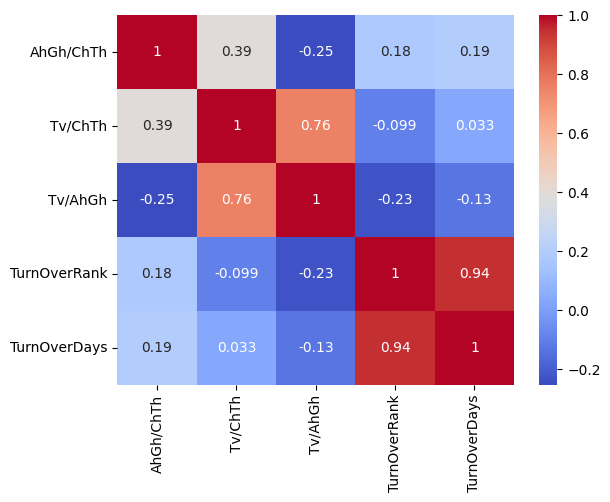

In [122]:
sns.heatmap(asymmetry_tcga_w_turn.corr('spearman'), annot=True, cmap='coolwarm')

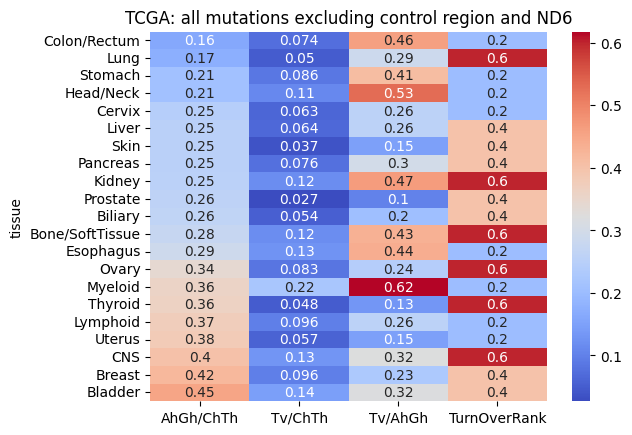

In [43]:
sns.heatmap(asymmetry_tcga_w_turn.sort_values('AhGh/ChTh'), 
            annot=True, cmap='coolwarm')#, cbar_kws={'label': 'asymmetry'})
plt.title('TCGA: all mutations excluding control region and ND6')
# plt.xticks(rotation=-90)
plt.show()

In [109]:
data = []
mut = mut_gtex_ex_ctrl_reg
for tissue, sample in mut.groupby('tissue'):
    if len(sample) < 20:
        print(f"Don't calculate spectrum for {tissue}: less than 20 mutations")
        continue

    spectrum = calculate_mutspec(sample, exp_muts12['ExDloop'], fill_unobserved=False)
    one = get_asymmetry(spectrum)
    data.append([tissue] + one)

asymmetry_gtex = pd.DataFrame(data, columns=['tissue', 'AhGh/ChTh', 'Tv/ChTh', 'Tv/AhGh'])\
                    .sort_values('AhGh/ChTh').set_index('tissue')

Don't calculate spectrum for Adipose - Visceral (Omentum): less than 20 mutations
Don't calculate spectrum for Artery - Coronary: less than 20 mutations
Don't calculate spectrum for Brain - Anterior cingulate cortex (BA24): less than 20 mutations
Don't calculate spectrum for Brain - Cerebellar Hemisphere: less than 20 mutations
Don't calculate spectrum for Brain - Cortex: less than 20 mutations
Don't calculate spectrum for Brain - Hippocampus: less than 20 mutations
Don't calculate spectrum for Brain - Hypothalamus: less than 20 mutations
Don't calculate spectrum for Brain - Nucleus accumbens (basal ganglia): less than 20 mutations
Don't calculate spectrum for Brain - Spinal cord (cervical c-1): less than 20 mutations
Don't calculate spectrum for Esophagus - Gastroesophageal Junction: less than 20 mutations
Don't calculate spectrum for Esophagus - Muscularis: less than 20 mutations
Don't calculate spectrum for Heart - Atrial Appendage: less than 20 mutations
Don't calculate spectrum fo

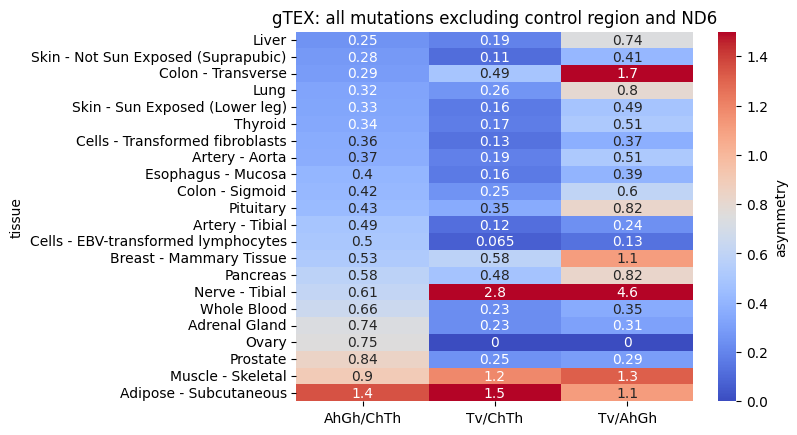

In [62]:
sns.heatmap(asymmetry_gtex, annot=True, cmap='coolwarm', cbar_kws={'label': 'asymmetry'}, vmax=1.5)
plt.title('gTEX: all mutations excluding control region and ND6');

In [123]:
mut_gtex_ex_ctrl_reg[mut_gtex_ex_ctrl_reg.tissue == 'Muscle - Skeletal'].Mut.str.slice(2, 5).value_counts()


T>C    12
G>A     7
A>G     6
T>A     5
C>T     3
G>C     3
A>C     3
A>T     1
G>T     1
Name: Mut, dtype: int64

In [44]:
# Nerve - Tibial samples contain a lot of G>T 
mut_gtex_ex_ctrl_reg[mut_gtex_ex_ctrl_reg.tissue == 'Nerve - Tibial'].Mut.str.slice(2, 5).value_counts()

G>T    25
A>G    20
T>C    14
G>A    12
C>T    11
G>C     6
A>T     4
T>A     1
A>C     1
C>A     1
Name: Mut, dtype: int64

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


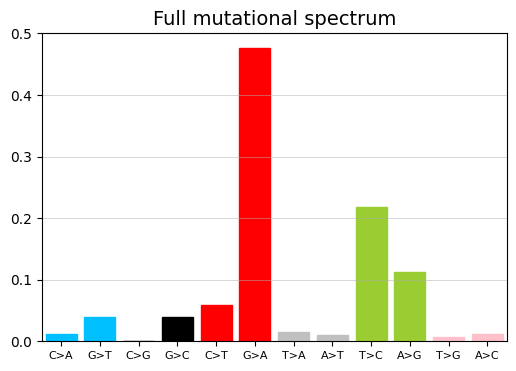

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [113]:
plot_mutspec12(calculate_mutspec(mut_gtex_ex_ctrl_reg, exp_muts12['ExDloop'], fill_unobserved=False))

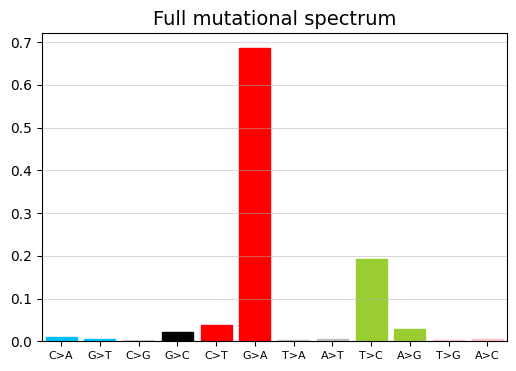

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [114]:
plot_mutspec12(calculate_mutspec(mut_tcga_ex_ctrl_reg, exp_muts12['ExDloop'], fill_unobserved=False))

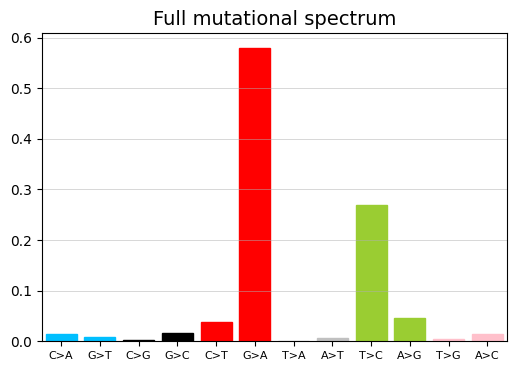

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [ ]:
plot_mutspec12(calculate_mutspec(mut_tcga[mut_tcga.GeneName == 'ND6'], exp_muts12['ExDloop']))

### Interval-based spectra
Features:
- cancer/tissue type
- location (TSSS)
- MutType (A>G, C>T, ratios, etc.)
- VAF (optionaly)

In [48]:
mut_tcga_ex_ctrl_reg.head()

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [47]:
mut_tcga_ex_ctrl_reg.Pos.describe().loc[['min', 'max']]

min      577.0
max    15941.0
Name: Pos, dtype: float64

In [85]:
genome_points = np.linspace(577, 15942, 15).astype(int)
print(genome_points)
site2genome_point = {}
for iid, (x,y) in enumerate(zip(genome_points[:-1], genome_points[1:]), 1):
    for i in range(x, y):
        site2genome_point[i] = iid

[  577  1674  2772  3869  4967  6064  7162  8259  9357 10454 11552 12649
 13747 14844 15942]


In [87]:
mut_tcga_ex_ctrl_reg['interval'] = mut_tcga_ex_ctrl_reg.Pos.map(site2genome_point)

In [105]:
mut_tcga_ex_ctrl_reg.groupby('interval').agg({'Pos':['min', 'max'], 'Mut': 'count'})

Pos          Mut
            min    max count
interval                    
1           577   1671   557
2          1682   2759   548
3          2772   3867   566
4          3877   4966   480
5          4969   6063   293
6          6065   7156   433
7          7164   8256   360
8          8259   9345   312
9          9359  10437   418
10        10456  11550   437
11        11552  12641   509
12        12650  13741   518
13        13752  14838   203
14        14846  15941   575

In [106]:
interval_tis_mut_counts = mut_tcga_ex_ctrl_reg.groupby([ 'interval', 'tissue',])\
    .Mut.count().rename('nmuts').unstack()
interval_tis_mut_counts.head(2)

tissue,Biliary,Bladder,Bone/SoftTissue,Breast,CNS,Cervix,Colon/Rectum,Esophagus,Head/Neck,Kidney,...,Lung,Lymphoid,Myeloid,Ovary,Pancreas,Prostate,Skin,Stomach,Thyroid,Uterus
interval,,,,,,,,,,,,,,,,,,,,,
1,7.0,3.0,12.0,50.0,10.0,1.0,20.0,32.0,18.0,51.0,...,19.0,43.0,6.0,20.0,52.0,66.0,20.0,13.0,8.0,9.0
2,4.0,11.0,12.0,60.0,21.0,1.0,19.0,27.0,13.0,46.0,...,16.0,23.0,6.0,34.0,65.0,53.0,15.0,14.0,8.0,11.0


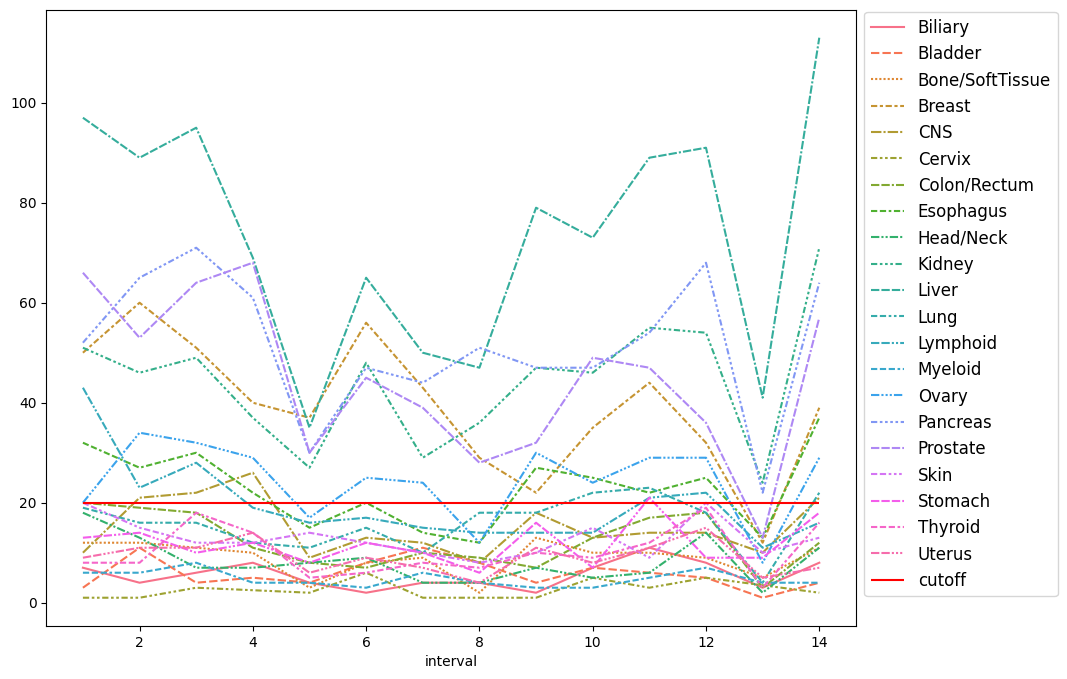

In [108]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(interval_tis_mut_counts)
plt.hlines(20, 1, 14, 'red', label='cutoff')
# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend

plt.show()

In [ ]:
sns.lineplot(data=mut_tcga_ex_ctrl_reg, x='Pos', y='Mut')

In [64]:
mut_tcga_ex_ctrl_reg.corr('spearman')

,TurnOverDays,tumor_var_freq,Pos,Strand,PosInGene,PosInCodon,TBSS,Label
TurnOverDays,1.000000,-0.019852,0.048193,NaN,0.021254,0.009772,0.026678,-0.022393
tumor_var_freq,-0.019852,1.000000,0.003078,NaN,-0.003412,-0.021104,0.017404,-0.008844
Pos,0.048193,0.003078,1.000000,NaN,0.615983,0.525719,0.515119,0.070756
Strand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PosInGene,0.021254,-0.003412,0.615983,NaN,1.000000,0.614670,0.269182,0.083562
PosInCodon,0.009772,-0.021104,0.525719,NaN,0.614670,1.000000,0.141600,0.458116
TBSS,0.026678,0.017404,0.515119,NaN,0.269182,0.141600,1.000000,0.003452
Label,-0.022393,-0.008844,0.070756,NaN,0.083562,0.458116,0.003452,1.000000


<AxesSubplot:xlabel='tumor_var_freq', ylabel='tissue'>

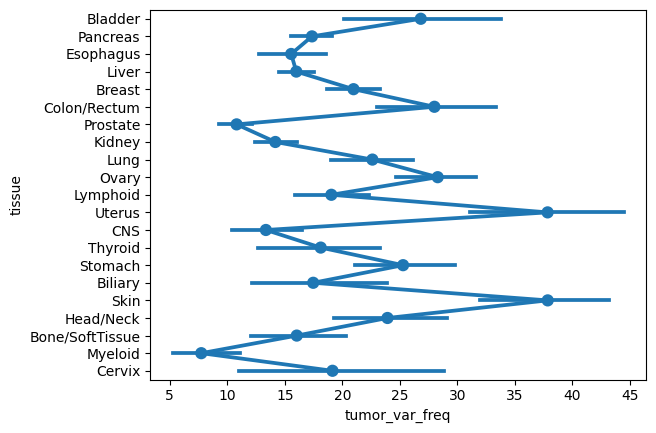

In [56]:
sns.pointplot(data=mut_tcga_ex_ctrl_reg, x='tumor_var_freq', y='tissue',)